In [1]:
import numpy as np
from ase.io import read,write
import pandas as pd
import glob
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
plt.style.use('~/plot.mplstyle')
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


/var/folders/z4/v8cnfld964b8x3vqdvtc45pr0000gr/T/ipykernel_43914/2344131061.py:121: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


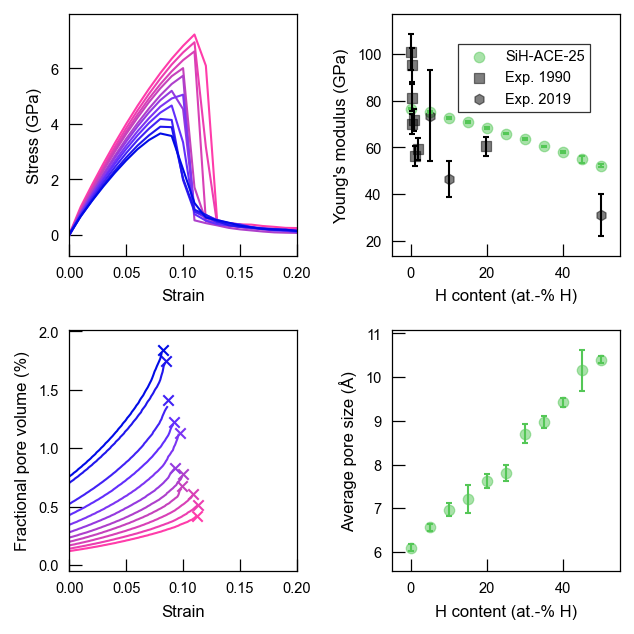

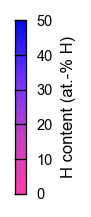

In [35]:
cms=1/2.54
# H concentrations
Hconcs = np.arange(0, 55, 5)
repeats=np.arange(1,6)
cut=100

# Define custom color scale
colors_rgb = [
    mcolors.to_rgb('#FF3CAA'),  
    mcolors.to_rgb('#BE43BE'),
    mcolors.to_rgb('#6C32FF'), 
    mcolors.to_rgb('#000BE6')   
]
custom_cmap = LinearSegmentedColormap.from_list('custom_hsla_gradient', colors_rgb)
norm = mcolors.Normalize(vmin=min(Hconcs), vmax=max(Hconcs))  # Normalize Hconc range 

# Use subplots to manage Axes
fig, axes = plt.subplots(2,2, figsize=(11*cms, 11*cms))

# Plotting
for Hconc in Hconcs:
    Es=[]
    stress=np.zeros((len(repeats), 3001))
    strain=np.zeros((len(repeats), 3001))

    strain_pores=np.arange(0, 0.3, 0.001)
    color = custom_cmap(norm(Hconc))
    pores=np.zeros((len(repeats), 300))
    radiis=np.zeros((len(repeats), 300))
    cell_vols=np.zeros((len(repeats), 300))
    pore_fractions=np.zeros((len(repeats), 300))

    try:
        for i in repeats:
            color = custom_cmap(norm(Hconc))
            file = f'../../data/paper/mechanical_testing/Hconc-{Hconc:.0f}/{i:.0f}/dump/strain_stress_1.dat'
            df = pd.read_csv(file, delimiter=' ', names=['strain_ite', 'strain', 'stress', 'pe'])
            
            stress[i-1,:]=df.stress.values
            strain[i-1,:]=df.strain.values
            
            E=np.polyfit(df.strain[1:500], df.stress[1:500], deg=1)[0]* 0.0001
            Es.append(E)

            pore_v=np.loadtxt(f'../../data/paper/mechanical_testing/Hconc-{Hconc:.0f}/{i:.0f}/pore_v-{cut}.txt')
            radii= np.loadtxt(f'../../data/paper/mechanical_testing/Hconc-{Hconc:.0f}/{i:.0f}/radii-{cut}.txt')
            cell_v=np.loadtxt(f'../../data/paper/mechanical_testing/Hconc-{Hconc:.0f}/{i:.0f}/cell_v-{cut}.txt')
            
            pores[i-1,:]=pore_v
            radiis[i-1,:]=radii
            cell_vols[i-1,:]=cell_v
            pore_fractions[i-1,:]=pore_v/cell_v


        stress_av=np.mean(stress, axis=0)
        strain_av=np.mean(strain, axis=0)

        axes[0,0].plot(strain_av[::100], stress_av[::100]* 0.0001, label=f'H={Hconc}', color=color)

        Es_av=np.mean(Es)
        Es_std=np.std(Es)
        axes[0,1].scatter(Hconc, Es_av,  color='#54C756', alpha=0.5, label='SiH-ACE-25')
        axes[0,1].errorbar(Hconc, Es_av, yerr=Es_std, color='#54C756', capsize=1.5)

        ind_max=int(np.round(np.argmax(stress_av)/10))-2

        pore_fraction_av=np.mean(pore_fractions, axis=0)
        axes[1,0].plot(strain_pores[:ind_max], pore_fraction_av[:ind_max]*100, color=color)
        axes[1,0].scatter(strain_pores[ind_max], pore_fraction_av[ind_max]*100,  color=color, marker='x', s=25)

        radii_av=np.mean(radiis, axis=0)
        radii_std=np.std(radiis, axis=0)
        axes[1,1].scatter(Hconc, radii_av[ind_max], color='#54C756', alpha=0.5, s=25)
        axes[1,1].errorbar(Hconc, radii_av[ind_max], yerr=radii_std[ind_max], color='#54C756', capsize=1.5)

    except:
        print(Hconc)
        print(i)
        continue

### Experimental
df_1990=pd.read_csv('../../data/paper/mechanical_testing/experimental/Jiang-1990-experimental.csv', names=['Hconc', 'E', 'Estd'])
axes[0,1].scatter(df_1990.Hconc, df_1990.E, marker='s', color='k', alpha=0.5, label='Exp. 1990')
axes[0,1].errorbar(df_1990.Hconc, df_1990.E, yerr=df_1990.Estd, color='k' ,capsize=1.5, ls='None')

df=pd.read_csv('../../data/paper/mechanical_testing/experimental/Jiang-2019-experimental.csv', names=['Hconc', 'E', 'Estd'])
axes[0,1].scatter(df.Hconc, df.E, marker='h', color='k', alpha=0.5, label='Exp. 2019')
axes[0,1].errorbar(df.Hconc, df.E, yerr=df.Estd, color='k',capsize=1.5, ls='None')


axes[0,0].set_xlim(left=0,right=0.2)
axes[0,0].set_xticks(np.arange(0,0.25, 0.05))
axes[0,0].set_xlabel('Strain')
axes[0,0].set_ylabel('Stress (GPa)')
axes[0,1].set_xlabel('H content (at.-% H)')
axes[0,1].set_ylabel("Young's modulus (GPa)")

handles, labels = axes[0,1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0,1].legend(by_label.values(), by_label.keys())

axes[1,0].set_xlim(left=0,right=0.1)
axes[1,0].set_xlabel('Strain')
axes[1,0].set_xticks(np.arange(0,0.25, 0.05))
axes[1,0].set_yticks(np.arange(0,2.5, 0.5))
axes[1,0].set_ylabel('Fractional pore volume (%)')
axes[1,1].set_xlabel('H content (at.-% H)')
axes[1,1].set_ylabel("Average pore size (Å)")

fig.tight_layout()
fig.savefig('tt_v4.svg')

# Colorbar
fig, ax = plt.subplots(figsize=(0.25, 1.5))
fig.subplots_adjust(left=0.3, right=0.6) 

sm = cm.ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label('H content (at.-% H)')
fig.tight_layout()